In [201]:
# from scipy.spatial.transform import Rotation
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import scipy
import pathlib
import h5py
# import healpy as hp

import astropy.units as u
from astropy.coordinates import SkyCoord 
# from astropy.stats import median_absolute_deviation as mad_
# from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
# import gala.dynamics as gd
import gala.coordinates as gc
from mwlmc import model as mwlmc_model
Model = mwlmc_model.MWLMC()

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Polygon
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


In [157]:
t_init=-5 #Gyr
rs = np.linspace(1, 500, 500)
rs_zeros = np.zeros(shape=(500,))
mwh_sph_pot = Model.mwhalo_fields(t_init, rs, rs_zeros, rs_zeros, 0)[:,4]/1e4 #divided by 10^4
interp_E_to_r = interp1d(mwh_sph_pot, rs, kind='cubic', fill_value="extrapolate")
interp_r_to_E = interp1d(rs, mwh_sph_pot, kind='cubic', fill_value="extrapolate")

Read in the DES streams data taken from Shipp+18 and Shipp+19

In [191]:
def galactic_coords(p, v):
    
    galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
    galcen_distance = 8.249*u.kpc
    
    posvel_gc = SkyCoord(x=p[:,0]*u.kpc, y=p[:,1]*u.kpc, z=p[:,2]*u.kpc,
                         v_x=v[:,0]*u.km/u.s, v_y=v[:,1]*u.km/u.s, v_z=v[:,2]*u.km/u.s ,
                         frame='galactocentric', galcen_distance=galcen_distance, galcen_v_sun=galcen_v_sun)
    posvel_galactic = posvel_gc.transform_to('galactic')
    posvel_galactic_rc = gc.reflex_correct(posvel_galactic)
    l, b, d = posvel_galactic_rc.l, posvel_galactic_rc.b, posvel_galactic_rc.distance
    pm_l_cosb, pm_b, rvs = posvel_galactic_rc.pm_l_cosb, posvel_galactic_rc.pm_b, posvel_galactic_rc.radial_velocity
    
    return l.value, b.value, d.value, pm_l_cosb.value, pm_b.value, rvs.value

In [158]:
def fig6(path_data, pots, pot_labels, real_data, plotname, savefig=False):

    fig, ax = plt.subplots(1,1, figsize=(5, 3))
    ax.tick_params(axis='x',which='both', top=False)
    
    for j in range(len(pots)): 

        with h5py.File(path + pots[j],'r') as file:
            energies = np.array(file['energies'])
            pm_ang = np.array(file['pm_misalignment'])
        
        E_bins = np.linspace(-11,-3,15)
        hist, bins = np.histogram(energies/1e4, E_bins)
        
        indices_in_bins = []
        for i in range(len(bins) - 1):
            indices = np.where((energies/1e4 >= bins[i]) & (energies/1e4 < bins[i+1]))[0]
            indices_in_bins.append(indices)
        
        plt.sca(ax)
        frac = []
        uncert = []
    
        for idx in indices_in_bins:
            pm_ang_bin = pm_ang[idx]
            if len(pm_ang_bin)==0:
                frac_high = np.nan
                uncert_high = 0
            else:
                above = len(pm_ang_bin[pm_ang_bin > 10])
                if above==0:
                    above=1 # to avoid divison by 0 below
                total = len(pm_ang_bin)
                frac_high = above / total
                uncert_high = frac_high * ((1/above) + (1/total))**0.5
            frac.append(frac_high)
            uncert.append(uncert_high)
        plt.ylabel(r'$f\left(E\,;\,\bar{\vartheta} > 10^{\circ} \right)$', fontsize=12)
                
        bin_mids = [(E_bins[i] + E_bins[i+1])/2 for i in range(len(E_bins) - 1)]
        rs = interp_E_to_r(bin_mids)

        if j==(len(pots)-1):
            plt.plot(bin_mids, frac, c='k', lw=2.5, label=labels[j], zorder=1)
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                             color='k', alpha=0.3, edgecolor='None')
        elif j==(len(pots)-2):
            plt.plot(bin_mids, frac, c='k', lw=2, ls='dashed', label=labels[j])
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                             color='k', alpha=0.1, edgecolor='None')
        else:    
            plt.plot(bin_mids, frac, lw=1, label=labels[j], zorder=2)
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                             alpha=0.1, edgecolor='None')
  
        plt.xlabel(r'$E\,[10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=12)

    xerr = np.array([interp_r_to_E(real_data['med_d'] + real_data['std_d']),
                               interp_r_to_E(real_data['med_d'] - real_data['std_d'])] )[:,np.newaxis]
    plt.errorbar(interp_r_to_E(real_data['med_d']), real_data['frac'],xerr=np.abs(xerr - interp_r_to_E(real_data['med_d'])),
                 marker='o', linestyle='None', ecolor='k',
                 capsize=5, mfc='red', mec='k', ms=5,
                label='DES streams')
    
    secax = ax.secondary_xaxis('top', functions=(interp_E_to_r, interp_r_to_E))
    secax.set_xlabel('Galactocentric radius [kpc]', color='grey', fontsize=12) 
    secax.tick_params(axis='x',which='both', colors='grey')


    plt.legend(frameon=False, ncol=1, fontsize=10)
    plt.xlim(-9.99,-4.01)
    plt.ylim(-0.02, 1.02)
    
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname))
    # plt.close()

In [159]:
def plot_metric_QUAD(ax, indices_in_bins, metric, threshold, y_label, title, colors, labels, bin_mids, mask_idx):
    ax.tick_params(axis='x',which='both', top=False)
    
    frac = []
    uncert = []
    for idx in indices_in_bins:
        metric_bin = metric[idx]
        if len(metric_bin) == 0:
            frac_high = 0
            uncert_high = 0
        else:
            above = len(metric_bin[metric_bin > threshold])
            if above == 0:
                above = 1  # to avoid division by 0 below
            total = len(metric_bin)
            frac_high = above / total
            uncert_high = frac_high * ((1 / above) + (1 / total))**0.5
        frac.append(frac_high)
        uncert.append(uncert_high)

    if mask_idx == 3: #mask_idx == 2 
        ax.plot(bin_mids, frac, lw=3, label=labels[mask_idx], c=colors[mask_idx])
        ax.fill_between(bin_mids, np.array(frac) - np.array(uncert), np.array(frac) + np.array(uncert),
                        alpha=0.3, ec='None', fc=colors[mask_idx])
    else:
        ax.plot(bin_mids, frac, lw=1, label=labels[mask_idx], c=colors[mask_idx])
        ax.fill_between(bin_mids, np.array(frac) - np.array(uncert), np.array(frac) + np.array(uncert),
                        fc=colors[mask_idx], alpha=0.2, ec='None',)

    ax.set_xlabel(r'$E\,[10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlim(-9.99, -4.01)
    ax.set_ylim(-0.02, 1.02)
    ax.set_title(title, fontsize=14)
    if mask_idx==0:
        secax = ax.secondary_xaxis('top', functions=(interp_E_to_r, interp_r_to_E))
        secax.set_xlabel('Galactocentric radius [kpc]', color='grey', fontsize=12) 
        secax.tick_params(axis='x',which='both', colors='grey')

In [160]:
def fig7(path_data, potl, real_data, labels, plotname, savefig=False):
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))

    print("Reading data...")
    with h5py.File(path_data + potl, 'r') as file:
        energies = np.array(file['energies'])
        pm_ang = np.array(file['pm_misalignment'])
        l_gc = np.array(file['l_gc'])
        b_gc = np.array(file['b_gc'])

    wrapped_l_gc = -np.where(l_gc >= 180, l_gc - 360, l_gc)
            
    mask_q1 = ((wrapped_l_gc > -180) & (wrapped_l_gc < 0) & (b_gc > 0) & (b_gc < 90))
    mask_q2 = ((wrapped_l_gc > 0) & (wrapped_l_gc < 180) & (b_gc > 0) & (b_gc < 90))
    mask_q3 = ((wrapped_l_gc > -180) & (wrapped_l_gc < 0) & (b_gc > -90) & (b_gc < 0))
    mask_q4 = ((wrapped_l_gc > 0) & (wrapped_l_gc < 180) & (b_gc > -90) & (b_gc < 0))
    masks = [mask_q1, mask_q2, mask_q3, mask_q4]

    E_bins = np.linspace(-11, -3, 15)
    bin_mids = [(E_bins[i] + E_bins[i + 1]) / 2 for i in range(len(E_bins) - 1)]

    # Define the colors for each quadrant
    colors = ['#EE7733', '#009988', '#33BBEE', '#EE3377']
    
    for m in range(len(masks)):
        print(f"Plotting Q{m + 1}")
        Es = energies[masks[m]]
        hist, bins = np.histogram(Es / 1e4, E_bins)

        indices_in_bins = []
        for i in range(len(bins) - 1):
            indices = np.where((Es / 1e4 > bins[i]) & (Es / 1e4 < bins[i + 1]))[0]
            indices_in_bins.append(indices)
        
        plot_metric_QUAD(ax, indices_in_bins, pm_ang[masks[m]], 10,
                    r'$f\left(E\,;\,\bar{\vartheta} > 10^{\circ} \right)$', 'Proper motion misalignment',
                    colors, labels, bin_mids, m)

    xerr = np.array([interp_r_to_E(real_data['med_d'] + real_data['std_d']),
                           interp_r_to_E(real_data['med_d'] - real_data['std_d'])] )[:,np.newaxis]
    plt.errorbar(interp_r_to_E(real_data['med_d']), real_data['frac'],xerr=np.abs(xerr - interp_r_to_E(real_data['med_d'])),
                 marker='o', linestyle='None', ecolor='k',
                 capsize=5, mfc='red', mec='k', ms=5, label='DES streams')

    ax.legend(frameon=False, ncol=1, fontsize=10)
    
    if savefig:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/paper-figs/{}'.format(plotname), bbox_inches='tight')
        print('Figure saved.')

In [161]:
# Stream names
streams = ["Aliqa Uma", "ATLAS", "Chenab", "Elqui", "Phoenix", "Tucana III", "Turranburra"]

# Proper motion data
mu_alpha_cos_delta = [0.25, -0.09, 0.32, 0.13, 2.76, -0.10, 0.43]
mu_alpha_cos_delta_error = [0.03, 0.03, 0.03, 0.04, 0.02, 0.04, 0.04]

mu_delta = [-0.71, -0.88, -2.47, -0.33, -0.05, -1.64, -0.89]
mu_delta_error = [0.05, 0.03, 0.04, 0.09, 0.02, 0.04, 0.04]

# Endpoints data
endpoints_start = {
    "Aliqa Uma": (31.7, -31.5),
    "ATLAS": (9.3, -20.9),
    "Chenab": (-40.7, -59.9),
    "Elqui": (10.7, -36.9),
    "Phoenix": (20.1, -55.3),
    "Tucana III": (-6.3, -59.7),
    "Turranburra": (59.3, -18.0) }

endpoints_end = {
    "Aliqa Uma": (40.6, -38.3),
    "ATLAS": (30.7, -33.2),
    "Chenab": (-28.3, -43.0),
    "Elqui": (20.6, -42.4),
    "Phoenix": (27.9, -42.7),
    "Tucana III": (3.2, -59.4),
    "Turranburra": (75.2, -26.4) }

# Distance data
distances = {
    "Aliqa Uma": 28.8,
    "ATLAS": 22.9,
    "Chenab": 39.8,
    "Elqui": 50.1,
    "Phoenix": 19.1,
    "Tucana III": 25.1,
    "Turranburra": 27.5 }

# Creating the DataFrame
data = {
    "mu_alpha_cos_delta": mu_alpha_cos_delta,
    "mu_alpha_cos_delta_error": mu_alpha_cos_delta_error,
    "mu_delta": mu_delta,
    "mu_delta_error": mu_delta_error,
    "endpoints_start_radec": [endpoints_start[stream] for stream in streams],
    "endpoints_end_radec": [endpoints_end[stream] for stream in streams],
    "distance_kpc": [distances[stream] for stream in streams] }

df = pd.DataFrame(data, index=streams)
df

,mu_alpha_cos_delta,mu_alpha_cos_delta_error,mu_delta,mu_delta_error,endpoints_start_radec,endpoints_end_radec,distance_kpc
Aliqa Uma,0.25,0.03,-0.71,0.05,"(31.7, -31.5)","(40.6, -38.3)",28.8
ATLAS,-0.09,0.03,-0.88,0.03,"(9.3, -20.9)","(30.7, -33.2)",22.9
Chenab,0.32,0.03,-2.47,0.04,"(-40.7, -59.9)","(-28.3, -43.0)",39.8
Elqui,0.13,0.04,-0.33,0.09,"(10.7, -36.9)","(20.6, -42.4)",50.1
Phoenix,2.76,0.02,-0.05,0.02,"(20.1, -55.3)","(27.9, -42.7)",19.1
Tucana III,-0.10,0.04,-1.64,0.04,"(-6.3, -59.7)","(3.2, -59.4)",25.1
Turranburra,0.43,0.04,-0.89,0.04,"(59.3, -18.0)","(75.2, -26.4)",27.5


### Making a crude proper motion misaignment measurements using the DES streams from Shipp+18,19

Getting the endpoints accounting for $\cos(\delta)$ factor and getting the normlaised stream track vector

In [162]:
start_ra = [np.array(df['endpoints_start_radec'])[i][0] for i in range(len(np.array(df['endpoints_start_radec']))) ]
start_dec = [np.array(df['endpoints_start_radec'])[i][1] for i in range(len(np.array(df['endpoints_start_radec']))) ]
# cos_start_dec = np.cos(np.array(start_dec) * np.pi/180)
start_radec = np.vstack((start_ra , start_dec) ).T

In [163]:
end_ra = [np.array(df['endpoints_end_radec'])[i][0] for i in range(len(np.array(df['endpoints_end_radec']))) ]
end_dec = [np.array(df['endpoints_end_radec'])[i][1] for i in range(len(np.array(df['endpoints_end_radec']))) ]
# cos_end_dec = np.cos(np.array(end_dec) * np.pi/180)
end_radec = np.vstack((end_ra , end_dec) ).T

In [177]:
av_ra = (np.array(start_ra) + np.array(end_ra)) * u.deg /2
av_dec = (np.array(start_dec) + np.array(end_dec)) * u.deg /2
# cos_av_dec = np.cos(np.array(av_dec) * np.pi/180)
av_radec = np.vstack((av_ra, av_dec) ).T

In [188]:
sky_coord = SkyCoord(ra=av_ra, dec=av_dec, frame='icrs')

# Convert to Galactic coordinates
galactic_coord = sky_coord.galactic
gc_l = galactic_coord.l.deg
gc_l = np.where(gc_l >= 180, gc_l - 360, gc_l)
gc_b = galactic_coord.b.deg

In [189]:
gc_l, gc_b

(array([-120.00200183, -146.14491341,  -14.75222104,  -66.85871658,
         -75.59913846,  -44.00240873, -140.21579135]),
 array([-68.64377799, -83.64317193, -47.08113531, -77.2652986 ,
        -66.49388157, -56.09215066, -40.69841676]))

In [165]:
track_vec_radec = -(end_radec - start_radec) * u.deg
track_vec_radec_mag = np.linalg.norm(track_vec_radec, axis=1)[:,np.newaxis]
track_vec_radec_norm = track_vec_radec / track_vec_radec_mag

track_err = np.array([0.0, 0.0]) * u.deg
track_vec_radec_norm_err = track_vec_radec_mag * track_err

Getting the normlaised proper motion vector

In [166]:
# pm_vec_radec = np.vstack((np.array(df['mu_alpha_cos_delta']) / cos_av_dec, 
#                           np.array(df['mu_delta']) ) ).T * (u.mas / u.yr)
pm_vec_radec = np.vstack((np.array(df['mu_delta']) ,
                        np.array(df['mu_alpha_cos_delta']) / cos_av_dec)).T * (u.mas / u.yr)
pm_vec_radec_mag =  np.linalg.norm(pm_vec_radec, axis=1)[:,np.newaxis]
pm_vec_radec_norm = pm_vec_radec / pm_vec_radec_mag

pm_vec_radec_err = np.vstack((np.array(df['mu_alpha_cos_delta_error']) / cos_av_dec,
                              np.array(df['mu_delta_error']) ) ).T * (u.mas / u.yr)
pm_vec_radec_norm_err = pm_vec_radec_mag * pm_vec_radec_err

Plotting the stream track and proper motion in (ra, dec) space and (l, b) Galactic coordinates

Text(0, 0.5, '$\\delta$ [deg]')

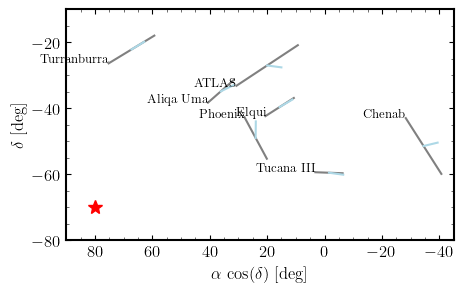

In [167]:
plt.figure(figsize=(5,3))

for (p1, p2), stream in zip(zip(start_radec, end_radec), streams):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'gray')
    plt.text(p2[0] , p2[1]  , stream , fontsize=9, ha='right')

for p1, p2 in zip(av_radec.value, av_radec.value + 5*pm_vec_radec_norm.value):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'lightblue')

plt.plot(80, -70, marker='*', c='r', ms=10)

plt.ylim(-80,-10)
plt.xlim(90, -45)

plt.xlabel(r'$\alpha \, \cos(\delta)$ [deg]')
plt.ylabel('$\delta$ [deg]')

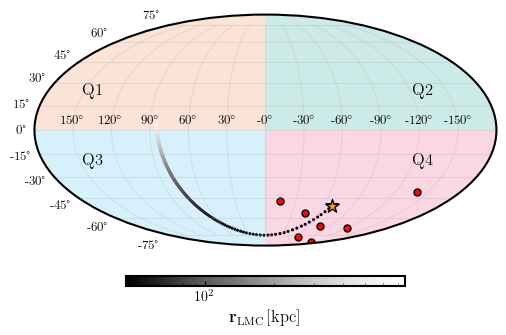

In [215]:
ts=np.linspace(-5, 0, 1000)
lmc_xs = [Model.expansion_centres(t)[6:9] for t in ts]
lmc_vs =  [Model.expansion_centre_velocities(t)[6:9] for t in ts]
lmc_l_gc, lmc_b_gc, *_ = galactic_coords(np.array(lmc_xs), np.array(lmc_vs))

disc_xs = [Model.expansion_centres(t)[:3] for t in ts]
lmc_dist_gc = np.linalg.norm(np.array(lmc_xs) - np.array(disc_xs), axis=1)

# Define the colors for each quadrant
colors = ['#EE7733', '#009988', '#33BBEE', '#EE3377']

fig, mollweide_ax = plt.subplots(1, 1, figsize=(6, 4), subplot_kw={'projection': 'mollweide'},)
plt.sca(mollweide_ax)
plt.grid(alpha=.25)    

# Define the vertices for the quadrants
quadrants = [
    Polygon([[-np.pi, 0], [0, 0], [0, np.pi / 2], [-np.pi, np.pi / 2]], closed=True),  # Top-left
    Polygon([[0, 0], [np.pi, 0], [np.pi, np.pi / 2], [0, np.pi / 2]], closed=True),    # Top-right
    Polygon([[-np.pi, -np.pi / 2], [0, -np.pi / 2], [0, 0], [-np.pi, 0]], closed=True),  # Bottom-left
    Polygon([[0, -np.pi / 2], [np.pi, -np.pi / 2], [np.pi, 0], [0, 0]], closed=True),    # Bottom-right
]

# Fill each quadrant with the respective color
for color, quad in zip(colors, quadrants):
    mollweide_ax.add_patch(quad)
    quad.set_facecolor(color)
    quad.set_alpha(0.2)

lmc_l_gc_wrap = np.where(lmc_l_gc >= 180, lmc_l_gc - 360, lmc_l_gc)
plt.scatter((-lmc_l_gc_wrap[-1]) * u.deg.to(u.rad), lmc_b_gc[-1] * u.deg.to(u.rad), s=100,
            edgecolors='k', facecolor='orange', marker='*', rasterized=True, zorder=2)
sc = plt.scatter((-lmc_l_gc_wrap) * u.deg.to(u.rad), lmc_b_gc * u.deg.to(u.rad), rasterized=True,
                 s=5, c=lmc_dist_gc, cmap='Greys_r', norm=LogNorm(vmin=45, vmax=750), lw=0, zorder=1)
cb=plt.colorbar(sc,location='bottom', aspect=30, pad=0.1, shrink=.6)
cb.set_label(r'$\mathbf{r}_{\mathrm{LMC}}\,[\mathrm{kpc}]$')
cb.ax.tick_params(labelsize=10)


plt.scatter( -gc_l* u.deg.to(u.rad), gc_b* u.deg.to(u.rad), facecolor='r', edgecolor='k')
    
mollweide_ax.annotate('Q1', (-5*np.pi/6, np.pi/8))
mollweide_ax.annotate('Q2', (4*np.pi/6, np.pi/8))
mollweide_ax.annotate('Q3', (-5*np.pi/6, -np.pi/8))
mollweide_ax.annotate('Q4', (4*np.pi/6, -np.pi/8))
mollweide_ax.tick_params( labelsize=9)

x_labels = mollweide_ax.get_xticks() * 180/np.pi
mollweide_ax.set_xticklabels(['{:.0f}'.format(-label) + r'$^{\circ}$' for label in x_labels])

# plt.show()

# plt.savefig('figures/mollweide/DES-streams')

Finding the misalignment angle between the stream track and proper motion vectors

In [168]:
track_dot_pm = np.einsum('ij,ij->i', track_vec_radec_norm.value, pm_vec_radec_norm.value) 
# track_dot_pm_err = np.linalg.norm(pm_vec_radec_norm_err / pm_vec_radec_norm, axis=1) #assuming pm error dominates

DES_pm_angles_rad = np.arccos(track_dot_pm) * u.rad
DES_pm_angles_deg = DES_pm_angles_rad.to(u.deg)
DES_pm_angles_deg = np.where(DES_pm_angles_deg > 90*u.deg, 180*u.deg - DES_pm_angles_deg, DES_pm_angles_deg)

df['pm_angle'] = list(np.round(DES_pm_angles_deg.value,2))

In [169]:
track_dot_pm_err = ( (track_vec_radec_norm_err/track_vec_radec_norm).value**2 
                    + (pm_vec_radec_norm_err/pm_vec_radec_norm).value**2 )**0.5
track_dot_pm_err = np.linalg.norm(track_dot_pm_err, axis=1)

DES_pm_angles_deg_err = track_dot_pm_err * (1 / (1 - track_dot_pm**2)**0.5)

In [170]:
df['pm_angle_err'] = list(np.round(DES_pm_angles_deg_err,2))
df

,mu_alpha_cos_delta,mu_alpha_cos_delta_error,mu_delta,mu_delta_error,endpoints_start_radec,endpoints_end_radec,distance_kpc,pm_angle,pm_angle_err
Aliqa Uma,0.25,0.03,-0.71,0.05,"(31.7, -31.5)","(40.6, -38.3)",28.8,14.15,0.42
ATLAS,-0.09,0.03,-0.88,0.03,"(9.3, -20.9)","(30.7, -33.2)",22.9,36.44,0.40
Chenab,0.32,0.03,-2.47,0.04,"(-40.7, -59.9)","(-28.3, -43.0)",39.8,65.48,0.56
Elqui,0.13,0.04,-0.33,0.09,"(10.7, -36.9)","(20.6, -42.4)",50.1,1.96,2.23
Phoenix,2.76,0.02,-0.05,0.02,"(20.1, -55.3)","(27.9, -42.7)",19.1,32.44,20.12
Tucana III,-0.10,0.04,-1.64,0.04,"(-6.3, -59.7)","(3.2, -59.4)",25.1,5.05,6.46
Turranburra,0.43,0.04,-0.89,0.04,"(59.3, -18.0)","(75.2, -26.4)",27.5,0.29,19.64


In [171]:
frac_DES_pms = len(df[df['pm_angle'] > 10]) / len(df)
mean_distance = np.mean(df['distance_kpc'])
std_distance = np.std(df['distance_kpc'])

In [172]:
DES_plot_data = {"frac" : frac_DES_pms,
                "med_d" : mean_distance,
                "std_d" : std_distance}

Plotting DES data point for median distance of streams and 1 std

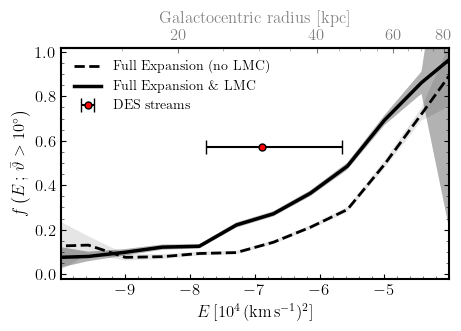

In [173]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/16384-dt1Myr/'
potentials = list(['full-MWhalo-full-MWdisc-no-LMC.hdf5', 'full-MWhalo-full-MWdisc-full-LMC.hdf5'])
labels = list(['Full Expansion (no LMC)', 'Full Expansion \& LMC'])

fig6(path, potentials, labels, DES_plot_data, 'fig6', False)

Reading data...
Plotting Q1
Plotting Q2
Plotting Q3
Plotting Q4
Figure saved.


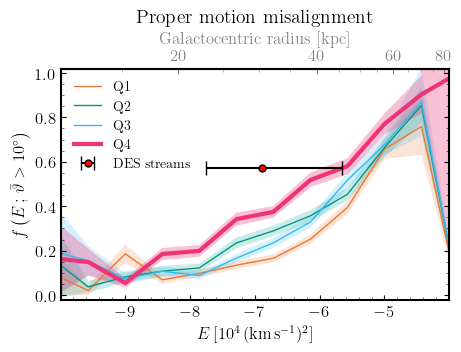

In [213]:
data_path='/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/16384-dt1Myr/'
potential_fig7 = 'full-MWhalo-full-MWdisc-full-LMC.hdf5'
labels_fig7 = list(['Q1','Q2','Q3','Q4'])
fig7(data_path, potential_fig7, DES_plot_data, labels_fig7, 'fig7', True)